In [1]:
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from rctorch import *
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint
%matplotlib inline

In [2]:
#! pip install rctorch==0.7161

In [3]:
#this method will ensure that the notebook can use multiprocessing on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline

In [4]:
lineW = 3
lineBoxW=2

font = {'family' : 'normal',
        'weight' : 'normal',#'bold',
        'size'   : 22}

#plt.rc('font', **font)
#plt.rcParams['text.usetex'] = True

def loss_plot(losses):
    for loss_hist in losses:
        plt.loglog(loss_hist, linewidth = lineW)
        plt.xlabel("epochs")
        plt.ylabel("RMSR")

In [5]:
#helper functions
def pltTr(x,y,clr='cyan', mark='o'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             marker=mark, color=clr, markersize=8, label='truth', alpha = 0.9)

def pltPred(x,y,clr='red', linS='-'):
    plt.plot(x.detach().numpy(), y.detach().numpy(),
             color=clr, marker='.', linewidth=2, label='RC')
from decimal import Decimal

def convert2pd(tensor1, tensor2):
    pd_ = pd.DataFrame(np.hstack((tensor1.detach().cpu().numpy(), tensor2.detach().cpu().numpy())))
    pd_.columns = ["t", "y"]
    return pd_
'%.2E' % Decimal('40800000000.00000000000000')

def param(t,N,y0):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    #f = t
    #f_dot=1
    return y0 + f*N

#define a reparameterization function
def reparam(t, y0 = None, N = None, dN_dt = None, t_only = False):
    f = 1 - torch.exp(-t)
    f_dot = 1 - f
    
    if t_only:
        return f, f_dot

    y = y0 + N*f 
    if dN_dt:
        ydot = dN_dt * f + f_dot * N
    else:
        ydot = None
    return y, ydot

def reparam(t, order = 1):
    exp_t = torch.exp(-t)
    
    derivatives_of_g = []
    
    g = 1 - exp_t
    
    #0th derivative
    derivatives_of_g.append(g)
    
    g_dot = 1 - g
    
    #first derivative
    #derivatives_of_g.append(g_dot)
    
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#     return derivatives_of_g
    return g, g_dot

def force(X, A = 0):
    return torch.zeros_like(X)

In [6]:
q = 0.5

        
def process(tensor_):
    """ takes a tensor and prepares it for plotting.
    """
    return tensor_.cpu().detach()

def custom_loss(X , y, ydot, out_weights, force_t = force, 
                reg = True, ode_coefs = None, q = q, 
                init_conds = None, enet_strength = None, enet_alpha = None,
                mean = True):
    """ The loss function of the ODE (in this case the bernoulli equation loss)
    Parameters
    ----------
    X: torch.tensor
        The input (in the case of ODEs this is time t)
    y: torch.tensor
        The response variable
    ydot: torch.tensor
        The time derivative of the response variable
    enet_strength: float
        the magnitude of the elastic net regularization parameter. In this case there is no e-net regularization
    enet_alpha: float
        the proportion of the loss that is L2 regularization (ridge). 1-alpha is the L1 proportion (lasso).
    ode_coefs: list
        this list represents the ODE coefficients. They can be numbers or t**n where n is some real number.
    force: function
        this function needs to take the input time tensor and return a new tensor f(t)
    reg: bool
        if applicable (not in the case below) this will toggle the elastic net regularization on and off
    reparam: function
        a reparameterization function which needs to take in the time tensor and return g and gdot, which 
        is the reparameterized time function that satisfies the initial conditions.
    init_conds: list
        the initial conditions of the ODE.
    mean: bool
        if true return the cost (0 dimensional float tensor) else return the residuals (1 dimensional tensor)
    q: float
        a bernoulli specific hyper-parameter
        
    Returns
    -------
    the residuals or the cost depending on the mean argument (see above)
    """
    #with paramization
    L =  ydot + ode_coefs[0]* y - force_t + q*y**2
    
#     if reg:
#         weight_size_sq = torch.mean(torch.square(out_weights))
#         weight_size_L1 = torch.mean(torch.abs(out_weights))
#         L_reg = 0.1*(weight_size_sq + weight_size_L1)/2
#         L = L + L_reg 
    
    L = torch.square(L)
    if mean:
         L = torch.mean(L)
    return L

In [51]:
def plot_rmsr(RC, results, force, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = process(RC.X)
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    force_t = force(X)
    for i, y in enumerate(ys):
        ydot = ydots[i]
        y = process(y)
        ydot = process(ydot)
        
        ode_coefs = covert_ode_coefs(t = X, ode_coefs = RC.ode_coefs)
        
        resids = custom_loss(X, y, ydot, None, 
                             force_t = force_t, 
                             ode_coefs = RC.ode_coefs,
                             mean = False)
        if not i:
            resids_tensor = resids
        else:
            resids_tensor = torch.cat((resids_tensor, resids), axis = 1)
        resids_specific_rmsr = torch.sqrt(resids/1) 
            
        ax.plot(X, resids_specific_rmsr, alpha = 0.7, linewidth = lineW -1)
        residuals.append(resids)
    
    mean_resid = torch.mean(resids_tensor, axis =1)
    rmsr = torch.sqrt(mean_resid)
#     ax.plot(X, rmsr, 
#                color = "blue", 
#                alpha = 0.9, 
#                label = r'{RMSR}')

    #ax.legend(prop={"size":16});
    
    ax.set_xlabel(r'$t$')
    ax.set_yscale("log")
    ax.set_ylabel(r'RMSR')

def covert_ode_coefs(t, ode_coefs):
    """ converts coefficients from the string 't**n' or 't^n' where n is any float
    Parameters
    ----------
    t: torch.tensor
        input time tensor
    ode_coefs: list
        list of associated floats. List items can either be (int/floats) or ('t**n'/'t^n')
    """
    type_t = type(t)
    for i, coef in enumerate(ode_coefs):
        if type(coef) == str:
            if coef[0] == "t" and (coef[1] == "*" or (coef[1] == "*" and coef[2] == "*")):
                pow_ = float(re.sub("[^0-9.-]+", "", coef))
                ode_coefs[i]  = t ** pow_
                print("alterning ode_coefs")
        elif type(coef) in [float, int, type_t]:
            pass
        else:
            assert False, "ode_coefs must be a list floats or strings of the form 't^pow', where pow is a real number."
    return ode_coefs

In [45]:

def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 0,
                        epochs = 30000,
                        custom_loss = custom_loss,
                        #loss_threshold = 10 ** -8,
                        EPOCHS_TO_TERMINATION = None,
                        force = force,
                        learning_rate = 0.01,
                        plott = False,
                        spikethreshold = 0.25):
    #define new_x
    new_X = esn.extended_states.detach()

    #force detach states_dot
    esn.states_dot = esn.states_dot.detach().requires_grad_(False)

    #define criterion
    criterion = torch.nn.MSELoss()
    
    try:
        assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
    except:
        esn.LinOut.weight.requires_grad_(True)
        esn.LinOut.bias.requires_grad_(True)
    #define previous_loss (could be used to do a convergence stop)
    previous_loss = 0

    #define best score so that we can save the best weights
    best_score = 0

    #define the optimizer
    optimizer = optim.Adam(esn.parameters(), lr = learning_rate)

    #define the loss history
    loss_history = []
    
    if plott:
        #use pl for live plotting
        fig, ax = pl.subplots(1,3, figsize = (16,4))
    
    t = esn.X#.view(*N.shape).detach()
    g, g_dot = esn.G
    y0  = esn.init_conds[0]
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    lrs = []
    
    floss_last = 0
    force_t = force(t)

    #begin optimization loop
    for e in range(epochs):

        optimizer.zero_grad()
        
        N = esn.forward( esn.extended_states )
        N_dot = esn.calc_Ndot(esn.states_dot)

        y = y0  + g *N 
        
        ydot = g_dot * N + g * N_dot

        #assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'
        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        
        #assert False, f'{esn.LinOut.weight}'

        total_ws = esn.LinOut.weight.shape[0] + 1
        weight_size_sq = torch.mean(torch.square(esn.LinOut.weight))
        
        loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = False, ode_coefs = esn.ode_coefs, force_t = force_t)
        loss.backward()
        optimizer.step()
        floss = float(loss)
        loss_history.append(floss)
        
        if not e and not best_score:
            best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()

        #if e > SAVE_AFTER_EPOCHS:
        if not best_score:
            best_score = float(loss)
            if floss <= min(loss_history):
                best_pred = y.clone()
                best_ydot = ydot.clone()
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
        else:
            if floss < best_score:
                best_pred = y.clone()
                best_ydot = ydot.clone()
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                best_score = float(loss)
                
        if EPOCHS_TO_TERMINATION:
            if e >= EPOCHS_TO_TERMINATION:
                backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
                return {"weights": best_weight, 
                        "best_score" : torch.tensor(best_score),
                        "bias" : best_bias, 
                        "loss" : backprop_args,
                        "ydot" : best_ydot, 
                        "y" : best_pred}
            
        if e > 1:
            if float(np.log(floss_last) - np.log(floss)) > spikethreshold:
                lrs.append(optimizer.param_groups[0]["lr"])
                scheduler.step()
                #for param_group in optimizer.param_groups:
                #    print('lr', param_group['lr'])
        floss_last = floss
        if plott:

            if e % 1500 == 0:
                ax[0].clear()
                logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                print(logloss_str + ", " + delta_loss)
                ax[0].plot(N.detach().cpu(), label = "exact")
                ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                ax[0].set_xlabel("epochs")

                ax[1].set_title(delta_loss)
                ax[1].plot(N_dot.detach().cpu())
                #ax[0].plot(y_dot.detach(), label = "dy_dx")
                ax[2].clear()
                weight_size = str(weight_size_sq.detach().item())
                ax[2].set_title("loss history \n and "+ weight_size)

                ax[2].loglog(loss_history)

                [ax[i].legend() for i in range(3)]
                previous_loss = loss.item()

                #clear the plot outputt and then re-plot
                display.clear_output(wait=True) 
                display.display(pl.gcf())
    backprop_args = {"loss_history" : loss_history, 
                         "lr" : learning_rate,
                         "epochs" : epochs
                        }
    return {"weights": best_weight, 
            "bias" : best_bias, 
            "loss" : backprop_args,
            "ydot" : best_ydot,
            "best_score" : torch.tensor(best_score), 
            "y" : best_pred}

In [9]:
# Scipy Solver   
def plot_predictions(RC, results, integrator_model, y0s = None,  ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = process(RC.X)
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    for i, y in enumerate(results["ys"]):
        y = process(y)
        if not i:
            labels = ["RC", "Integrator Solution"]
        else:
            labels = [None, None]
        ax.plot(X, y, label = labels[0], linewidth = lineW + 2, alpha = 0.9)

        #calculate the integrator prediction:
        int_sol = odeint(integrator_model, y0s[i], np.array(X.cpu().squeeze()))
        int_sol = torch.tensor(int_sol)
        
        #plot the integrator prediction
        ax.plot(X, int_sol, '--', color = "black", alpha = 0.95, label = labels[1],  linewidth = lineW - 1)
    
    plt.ylabel(r'$y(t)$');
    ax.legend();
    ax.tick_params(labelbottom=False)
    plt.tight_layout()

In [10]:
#optimized_hyper_params

In [11]:
x0,xf, nsteps = 0, 5, 1000 #int(2000 * ratio_up)
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

In [12]:
BURN_IN = 500

y0 = 1 ; lam = 1

#the length of xtrain won't matter. Only dt , x0, and xf matter.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)
xtrain.shape

torch.Size([1000, 1])

In [14]:
dRay=0.75
np.arange(-1., 1 + dRay, dRay)

array([-1.  , -0.25,  0.5 ,  1.25])

dt -2.1
n_nodes 500
connectivity -3.8727548122406006
spectral_radius 7.1109442710876465
regularization -2.392099618911743
leaking_rate 0.022500092163681984
bias 0.7761751413345337

In [15]:
log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']

hps = {'dt': 0.01,
 'n_nodes': 500,
 'connectivity': 0.0008771738385033052,
 'spectral_radius': 3.8187756538391113,
 'regularization': 2.6243606290132924,
 'leaking_rate': 0.05788800120353699,
 'bias': -0.4182356595993042}

for key, val in hps.items():
    if key in log_vars:
        print(key, np.log10(val))
    else:
        print(key, val)

dt -2.0
n_nodes 500
connectivity -3.0569143295288086
spectral_radius 3.8187756538391113
regularization 0.4190235137939453
leaking_rate 0.05788800120353699
bias -0.4182356595993042


In [16]:
dRay=0.75
y0s = np.arange(-1., 1 + dRay, dRay)
y0s = list(y0s)
y0s

[-1.0, -0.25, 0.5, 1.25]

FAIL
CPU times: user 51min 15s, sys: 28.7 s, total: 51min 44s
Wall time: 51min 21s


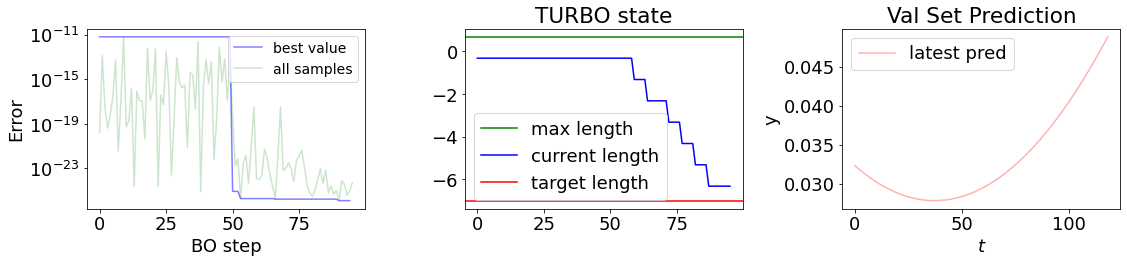

In [17]:
%%time
#declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = {"connectivity" : (-4, -0.1), 
               "spectral_radius" : (1.5, 8.5),
               "n_nodes" : 500,
               "regularization" : (-2, 2),
               "leaking_rate" : (0, 0.1),
               #"input_scaling" : (0, 1),
               #"feedback_scaling" : (0, 1),
               "dt" : -2,
               "bias": (-1,1)
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
esn_cv = EchoStateNetworkCV(bounds = bounds_dict,
                            interactive = True, 
                            batch_size = 1, cv_samples = 2, initial_samples = 50,  #200
                            subsequence_length = int(xtrain.shape[0] * 0.8),
                            random_seed = 209, success_tolerance = 10,
                            windowsOS =False, validate_fraction = 0.3, 
                            ODE_order = 1, length_min = 2 **(-7),
                            esn_burn_in = BURN_IN, log_score = True
                            )
#optimize:
opt = True
if opt:
    
    opt_hps = esn_cv.optimize(y = None, x = xtrain,#.cuda(),
                        reparam_f = reparam, 
                        ODE_criterion = custom_loss,
                        init_conditions = [y0s, ], 
                        force = force,
                        rounds = 5,
                        ode_coefs = [1, 1],
                        backprop_f = optimize_last_layer, 
                        solve = True,
                         q = q,
                         n_outputs = 1,
                         eq_system = False,
                         nonlinear_ode = True,

                         epochs = 5000) #
#

In [25]:
def recover_hps(esn_cv, idx):
    
    X_turbo, Y_turbo = esn_cv.X_turbo, esn_cv.Y_turbo
    #best_vals = X_turbo[idx]
    
    mask = esn_cv.Y_turbo.squeeze() > 0
    Y_Turbo_best = esn_cv.Y_turbo[ mask]
    X_Turbo_best = esn_cv.X_turbo[ mask, :]
    
    best_vals = X_Turbo_best[idx]
    
    #best_vals = X_turbo[torch.argmin(Y_turbo)]
    
    denormed_ = esn_cv.denormalize_bounds(best_vals)
        
    try:
        denormed_ = denormalize_bounds(best_vals)
    except:
        print("FAIL")

    best_vals = X_turbo[torch.argmax(Y_turbo)]

    #####Bad temporary code to change it back into a dictionary
    denormed_free_parameters = list(zip(esn_cv.free_parameters, denormed_))
    denormed_free_parameters = dict([ (item[0], item[1].item()) for item in denormed_free_parameters])

    best_hyper_parameters = denormed_free_parameters
    for fixed_parameter in esn_cv.fixed_parameters:
        best_hyper_parameters = {fixed_parameter : esn_cv.bounds[fixed_parameter], **best_hyper_parameters }

    #log_vars = ['connectivity', 'llambda', 'llambda2', 'noise', 'regularization', 'dt']
    for var in esn_cv.log_vars:
        if var in best_hyper_parameters:
            best_hyper_parameters[var] = 10. ** best_hyper_parameters[var] 
    return best_hyper_parameters

recover_hps(esn_cv, 0)

FAIL


{'bias': 0.9490906000137329,
 'connectivity': 0.00024854583199299384,
 'dt': 0.01,
 'leaking_rate': 0.009424317628145218,
 'n_nodes': 500,
 'regularization': 0.02499297583727001,
 'spectral_radius': 3.27508282661438}

In [32]:
#an amazing run, beating the published solutions:

#result published in the paper
# hybrid_hps_q05 = {'dt': 0.007943282347242814,
#  'n_nodes': 500,
#  'connectivity': 0.0003179179463749722,
#  'spectral_radius': 7.975825786590576,
#  'regularization': 0.3332787303378571,
#  'leaking_rate': 0.07119506597518921,
#  'bias': -0.9424528479576111}

#some very strong results found after submission
opt_hps1 = {'bias': 0.9490906000137329,
 'connectivity': 0.00024854583199299384,
 'dt': 0.01,
 'leaking_rate': 0.009424317628145218,
 'n_nodes': 500,
 'regularization': 0.02499297583727001,
 'spectral_radius': 3.27508282661438}
 #the strongest result:
opt_hps2 = {'bias': 0.5885217189788818,
 'connectivity': 0.6173509376804103,
 'dt': 0.01,
 'leaking_rate': 0.006605937611311674,
 'n_nodes': 500,
 'regularization': 2.8410215084453037,
 'spectral_radius': 5.8741302490234375}



In [33]:
train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : force,
              "reparam_f" : reparam,
              "init_conditions" : [y0s],
              "ode_coefs" : [1, 1],
              "X" : xtrain.view(-1,1),
              "q" : q,
              "nl" : True,
              }

In [41]:
%%time
EPOCHS = 50000
RC = EchoStateNetwork(**opt_hps,
                      random_state = 209, 
                      dtype = torch.float32)

# backprop_results = RC.fit( backprop_f = optimize_last_layer,
#                            train_score = True, 
#                            ODE_criterion = custom_loss,
#                            SOLVE = False,
#                            **train_args,
#                            epochs = EPOCHS)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [47]:
%%time
hybrid_results = RC.fit(backprop_f = optimize_last_layer,
                        train_score = True, 
                        ODE_criterion = custom_loss,
                        SOLVE = True,
                        **train_args,
                        epochs = EPOCHS)

CPU times: user 2min 48s, sys: 354 ms, total: 2min 49s
Wall time: 2min 48s


In [48]:
def Bernoulli_model(y,t, q = q):
    k = 1
    dydt = -k * y -q*y**2
    return dydt

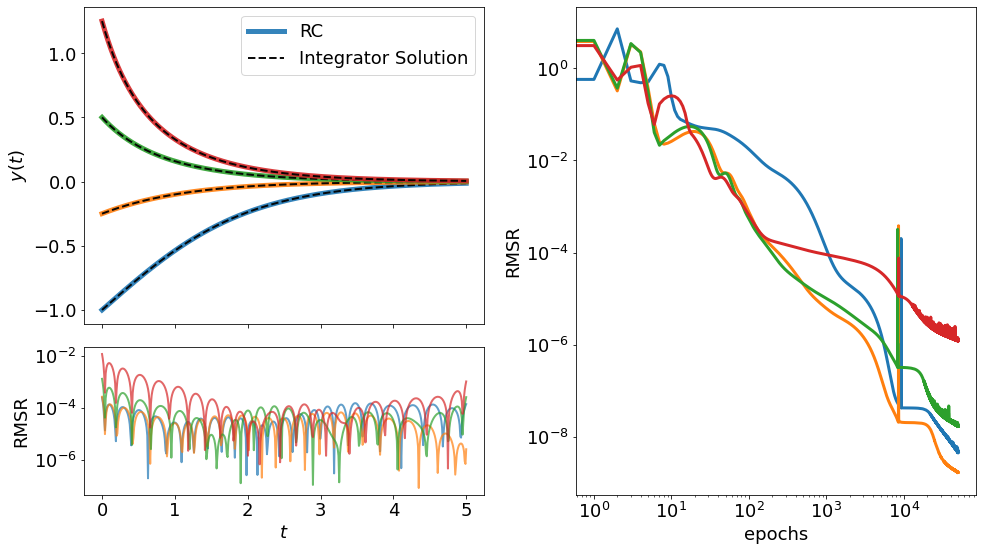

In [52]:
#show results:
fig = plt.figure(figsize = (14,8)); gs1 = gridspec.GridSpec(3, 3);
gs1 = gridspec.GridSpec(3, 6)
horiz_boundary = -3
vert_boundary = -1

g1, g2, g3 = gs1[:vert_boundary, :horiz_boundary], gs1[vert_boundary, :horiz_boundary], gs1[:, horiz_boundary:]
ax=plt.subplot(g1)

plot_predictions(RC, hybrid_results, Bernoulli_model, y0s, ax = ax)

ax=plt.subplot(g2)
plot_data = plot_rmsr(RC, 
                      hybrid_results, 
                      force = force, 
                      ax = ax)

plt.subplot(g3)
loss_plot(hybrid_results["losses"])
plt.tight_layout()